##Airbnb vs Hotel Booking Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from google.colab import files
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [5]:
df = pd.read_excel("/content/drive/MyDrive/Airbnb proj/1730285881-Airbnb_Open_Data.xlsx")
print("\nInitial shape:", df.shape)
print("Columns:", df.columns.tolist())


Initial shape: (102599, 26)
Columns: ['id', 'NAME', 'host id', 'host_identity_verified', 'host name', 'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country', 'country code', 'instant_bookable', 'cancellation_policy', 'room type', 'Construction year', 'price', 'service fee', 'minimum nights', 'number of reviews', 'last review', 'reviews per month', 'review rate number', 'calculated host listings count', 'availability 365', 'house_rules', 'license']


In [6]:
# 2️⃣ Quick inspect, dtypes, missing values, and basic cleaning
# ----------------------------------------------------------------
print("\n--- Info ---")
display(df.head(3))
print(df.info())

# Missing values
print("\nTop missing counts:")
print(df.isna().sum().sort_values(ascending=False).head(20))

# Normalize column names (lower, strip)
df.columns = [c.strip() for c in df.columns]
cols_lower = {c: c.lower().strip() for c in df.columns}
df.rename(columns=cols_lower, inplace=True)

# remove exact duplicates
dups = df.duplicated().sum()
if dups>0:
    df = df.drop_duplicates()
    print(f"\nRemoved {dups} duplicate rows. New shape: {df.shape}")

# Helper: detect common columns
colset = set(df.columns)
def has(*cands):
    for c in cands:
        if c in colset:
            return c
    return None


--- Info ---


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              102599 non-null  int64         
 1   NAME                            102329 non-null  object        
 2   host id                         102599 non-null  int64         
 3   host_identity_verified          102310 non-null  object        
 4   host name                       102191 non-null  object        
 5   neighbourhood group             102570 non-null  object        
 6   neighbourhood                   102583 non-null  object        
 7   lat                             102591 non-null  float64       
 8   long                            102591 non-null  float64       
 9   country                         102067 non-null  object        
 10  country code                    102468 non-null  object 

In [7]:
# Candidate column names mapping (you may adjust if your file uses different names)
col_price = has('price','Price','listing_price','night_price')
col_lat = has('lat','latitude')
col_long = has('long','longitude','lon')
col_neigh = has('neighbourhood','neighborhood','neighbourhood group','neighbourhood_cleansed')
col_room = has('room type','room_type')
col_reviews = has('number of reviews','number_of_reviews','reviews')
col_last_review = has('last review','last_review','last_review_date')
col_host_response_time = has('host response time','host_response_time')
col_host_listings_count = has('host listings count','host_listings_count','host listings')
col_host_id = has('host id','host_id')
col_amenities = has('amenities','features','amenities_list')
col_availability = has('availability 365','availability365','availability')
col_minimum_nights = has('minimum nights','minimum_nights')
col_name = has('name','listing name','name')

print("\nDetected key columns:")
print("price:", col_price)
print("lat:", col_lat, "long:", col_long)
print("neighbourhood:", col_neigh)
print("room type:", col_room)
print("reviews:", col_reviews)
print("last_review:", col_last_review)
print("host id:", col_host_id)
print("amenities:", col_amenities)


Detected key columns:
price: price
lat: lat long: long
neighbourhood: neighbourhood
room type: room type
reviews: number of reviews
last_review: last review
host id: host id
amenities: None


In [8]:
# 3️⃣ Data type conversions
# ------------------------------
if col_price:
    # strip currency signs & commas if price stored as string
    df[col_price] = df[col_price].astype(str).str.replace(r'[^0-9.\-]', '', regex=True)
    df[col_price] = pd.to_numeric(df[col_price], errors='coerce')

# Parse last review / booking date columns if present
date_cols = []
for c in df.columns:
    if 'date' in c or 'day' in c or 'time' in c:
        date_cols.append(c)
# Also ensure the detected last_review is parsed
if col_last_review:
    try:
        df[col_last_review] = pd.to_datetime(df[col_last_review], errors='coerce')
        date_cols.append(col_last_review)
    except:
        pass

print("\nParsed date columns:", list(set(date_cols)))



Parsed date columns: ['last review']


In [9]:
# 4️⃣ Imputation: numeric -> median, categorical -> mode
# -------------------------------------------
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

for c in num_cols:
    if df[c].isna().sum()>0:
        df[c] = df[c].fillna(df[c].median())

for c in cat_cols:
    if df[c].isna().sum()>0:
        mode = df[c].mode()
        df[c] = df[c].fillna(mode[0] if not mode.empty else "Unknown")

print("\nImputation complete. Remaining nulls (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))



Imputation complete. Remaining nulls (top 10):
last review               15832
id                            0
host id                       0
host_identity_verified        0
host name                     0
neighbourhood group           0
neighbourhood                 0
lat                           0
long                          0
name                          0
dtype: int64


In [10]:
# 5️⃣ Outlier treatment (IQR capping) for numeric cols
# -------------------------------------------------
def cap_iqr(series):
    if series.dropna().shape[0] < 5:
        return series
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series.clip(lower, upper)

for c in num_cols:
    df[c] = cap_iqr(df[c])

In [11]:
# 6️⃣ Feature engineering relevant to objectives
# ------------------------------------------
# Booking patterns: create booking_date features if available
if col_last_review and col_last_review in df.columns:
    df['last_review_year'] = df[col_last_review].dt.year
    df['last_review_month'] = df[col_last_review].dt.month
    df['last_review_weekday'] = df[col_last_review].dt.weekday

# Price per guest (if accommodates present)
col_accom = has('accommodates','guests','guests_included')
if col_price and col_accom:
    df['price_per_person'] = df[col_price] / df[col_accom].replace({0:np.nan})
    df['price_per_person'] = df['price_per_person'].fillna(df[col_price].median())

# Amenity engineering: count amenities if amenities text exists
if col_amenities and col_amenities in df.columns:
    # many datasets store amenities as string like "{Wifi,TV,Kitchen}"
    df['amenities_count'] = df[col_amenities].astype(str).apply(lambda x: len(x.replace('{','').replace('}','').split(',')) if x not in ['nan','None'] else 0)

# Host responsiveness mapping (if host_response_time column exists)
if col_host_response_time and col_host_response_time in df.columns:
    # normalize textual response times into ordered numeric
    mapping = {
        'within an hour': 1,
        'within a few hours': 2,
        'within a day': 3,
        'a few days or more': 4
    }
    df['host_response_time_score'] = df[col_host_response_time].map(mapping).fillna(4)



=== Booking Patterns ===


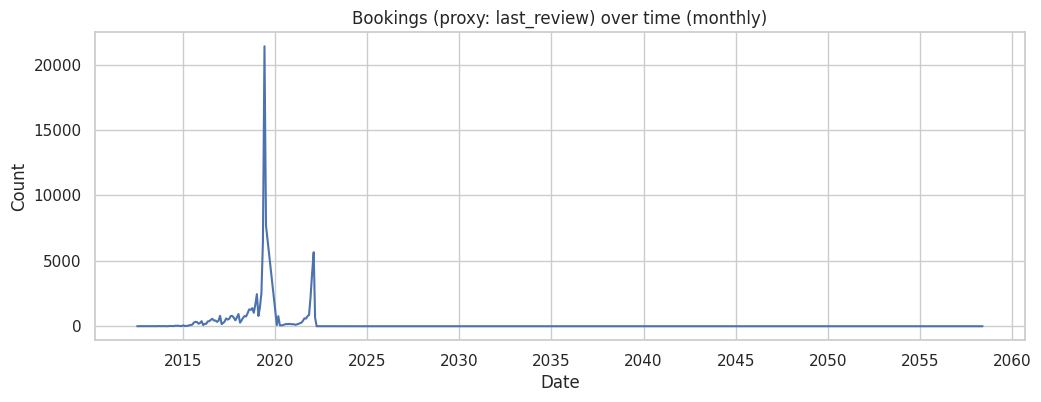

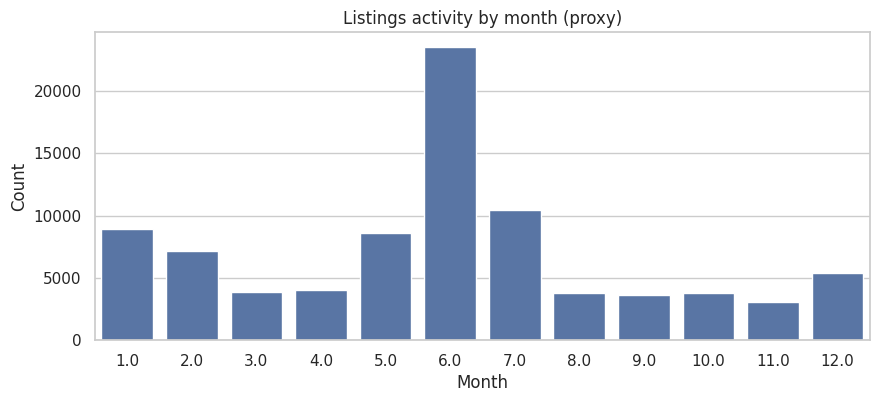

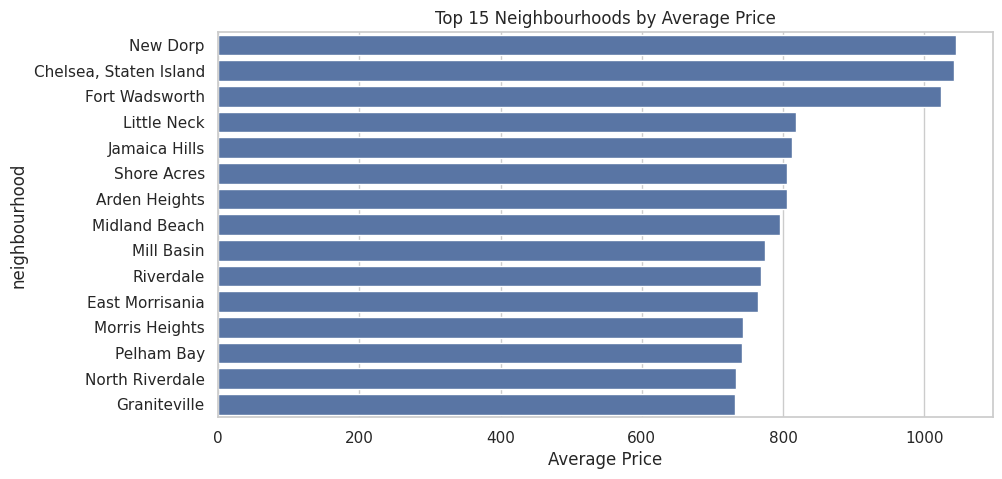

In [12]:
# 7️⃣ Exploratory Analysis  — Booking Patterns
# ----------------------------------------------------
print("\n=== Booking Patterns ===")

# If date-like booking info exists, analyze seasonal trends
if col_last_review and df[col_last_review].notna().sum() > 10:
    # aggregate counts by month-year
    monthly = df.groupby(['last_review_year','last_review_month']).size().reset_index(name='count')
    monthly['date'] = pd.to_datetime(monthly['last_review_year'].astype(int).astype(str) + '-' + monthly['last_review_month'].astype(int).astype(str) + '-01')
    plt.figure(figsize=(12,4))
    sns.lineplot(x='date', y='count', data=monthly)
    plt.title("Bookings (proxy: last_review) over time (monthly)")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.show()
    # Average lead time: if you have 'booking_date' and 'checkin_date' use that; else skip
else:
    print("No usable date column for booking timeline. If you have a booking-date column, rename it to include 'date' or specify it.")

# Peak seasons by month (if we have month info)
if 'last_review_month' in df.columns:
    month_counts = df['last_review_month'].value_counts().sort_index()
    plt.figure(figsize=(10,4))
    sns.barplot(x=month_counts.index, y=month_counts.values)
    plt.title("Listings activity by month (proxy)")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.show()

# Variation by location: average price per neighbourhood
if col_price and col_neigh:
    top_neigh = df.groupby(col_neigh)[col_price].mean().sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_neigh.values, y=top_neigh.index)
    plt.title("Top 15 Neighbourhoods by Average Price")
    plt.xlabel("Average Price")
    plt.show()


=== Pricing Strategies ===


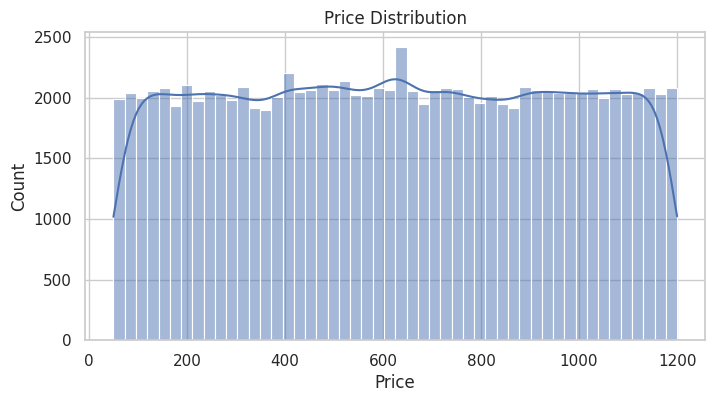

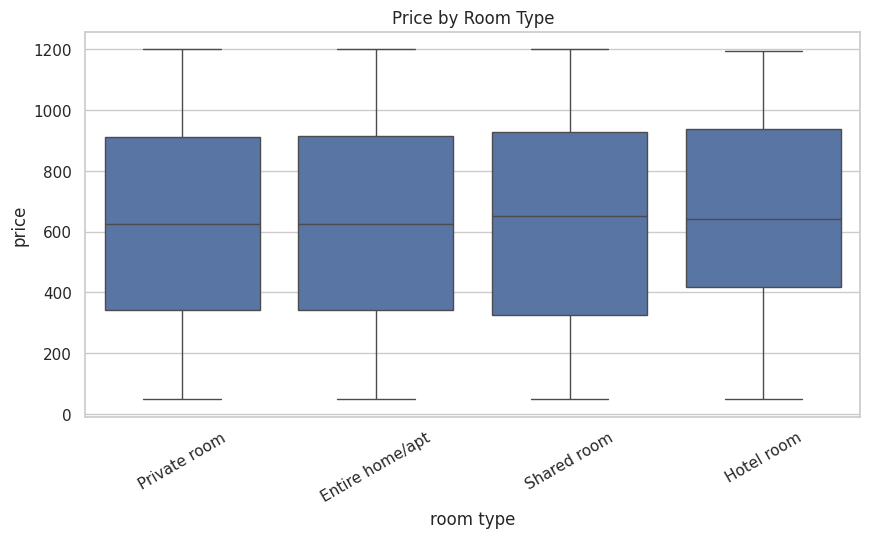

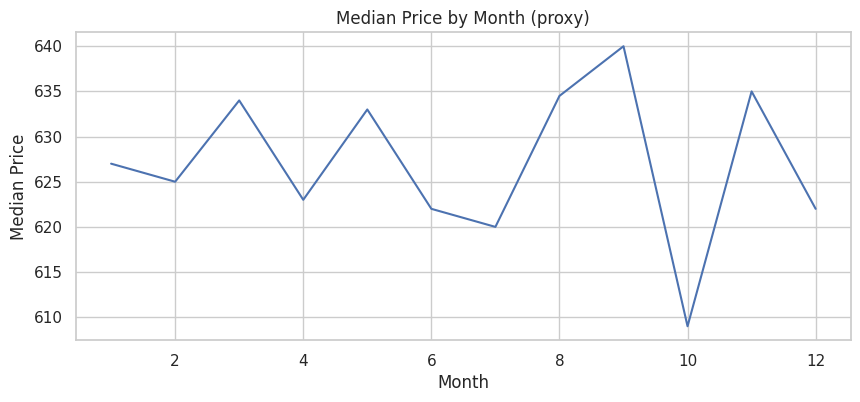

In [13]:
# 8️⃣ Pricing Strategies — distributions, seasonality
# ----------------------------------------------------
print("\n=== Pricing Strategies ===")
if col_price:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col_price], bins=50, kde=True)
    plt.title("Price Distribution")
    plt.xlabel("Price")
    plt.show()

    # price by room type
    if col_room:
        plt.figure(figsize=(10,5))
        sns.boxplot(x=col_room, y=col_price, data=df)
        plt.title("Price by Room Type")
        plt.xticks(rotation=30)
        plt.show()

    # Price vs amenities_count
    if 'amenities_count' in df.columns:
        plt.figure(figsize=(8,4))
        sns.scatterplot(x='amenities_count', y=col_price, data=df, alpha=0.4)
        plt.title("Price vs Amenities Count")
        plt.show()

    # Monthly average price if date exists
    if 'last_review_month' in df.columns:
        monthly_price = df.groupby('last_review_month')[col_price].median().reindex(range(1,13))
        plt.figure(figsize=(10,4))
        sns.lineplot(x=monthly_price.index, y=monthly_price.values)
        plt.title("Median Price by Month (proxy)")
        plt.xlabel("Month")
        plt.ylabel("Median Price")
        plt.show()
else:
    print("No price column detected — skip pricing analysis.")

In [14]:
# 9️⃣ Guest Preferences — amenities and ratings
# ----------------------------------------------------
print("\n=== Guest Preferences ===")
# Amenities most common
if col_amenities:
    # explode amenities into rows (attempt)
    def split_amenities(text):
        try:
            s = text.strip()
            # remove braces
            s = s.replace('{','').replace('}','')
            items = [i.strip().lower() for i in s.split(',') if i.strip()!='']
            return items
        except:
            return []
    amenities_series = df[col_amenities].astype(str).apply(split_amenities)
    # flatten to counts
    from collections import Counter
    cnt = Counter()
    for lst in amenities_series:
        cnt.update(lst)
    common_amen = pd.Series(dict(cnt)).sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x=common_amen.values, y=common_amen.index)
    plt.title("Top 20 Amenities (by occurrence)")
    plt.xlabel("Count")
    plt.show()
else:
    print("No amenities column found — skip amenities analysis.")

# Ratings & satisfaction (if review score columns exist)
col_rating = has('review_scores_rating','rating','review score')
if col_rating:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col_rating], bins=30, kde=True)
    plt.title("Distribution of Ratings")
    plt.show()

    # correlation between rating and price
    if col_price:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=col_price, y=col_rating, data=df, alpha=0.4)
        plt.title("Price vs Rating")
        plt.show()
else:
    print("No rating column detected — skip rating analysis.")



=== Guest Preferences ===
No amenities column found — skip amenities analysis.
No rating column detected — skip rating analysis.


In [15]:
# 🔟 Host Performance — identifying high-performers
# ----------------------------------------------------
print("\n=== Host Performance ===")
if col_host_id:
    host_metrics = df.groupby(col_host_id).agg({
        col_price: ['mean','count'] if col_price else ('listing_count', 'count'),
        col_reviews: 'sum' if col_reviews else 'size'
    }).fillna(0)

    # Flatten columns
    host_metrics.columns = ['_'.join(map(str, c)).strip() for c in host_metrics.columns.values]
    host_metrics = host_metrics.reset_index().rename(columns={host_metrics.columns[0]:col_host_id})
    # Top hosts by number of listings / revenue proxy
    if col_price:
        host_metrics['total_revenue_proxy'] = host_metrics[[c for c in host_metrics.columns if 'mean' in c and col_price in c]].sum(axis=1) * host_metrics[[c for c in host_metrics.columns if 'count' in c and col_price in c]].sum(axis=1)
    # top by listing count
    top_hosts = host_metrics.sort_values(by=[col_price + '_count' if col_price else host_metrics.columns[1]], ascending=False).head(10)
    display(top_hosts.head(10))
else:
    print("No host id column found — skip host performance.")

# Host responsiveness effect (if we created score)
if 'host_response_time_score' in df.columns and col_reviews:
    resp = df.groupby('host_response_time_score')[col_reviews].mean().reset_index()
    plt.figure(figsize=(7,4))
    sns.barplot(x='host_response_time_score', y=col_reviews, data=resp)
    plt.title("Avg reviews by host response time score (proxy for engagement)")
    plt.show()


=== Host Performance ===


,host id,host id,price_count,number of reviews_sum,total_revenue_proxy
30642,29531702698,1092.0,2,1.0,0.0
68046,65765635975,238.0,1,2.0,0.0
68045,65765267302,456.0,1,2.0,0.0
68044,65764671629,863.0,1,4.0,0.0
68043,65764610014,682.0,1,63.0,0.0
68042,65761971530,1092.0,1,1.0,0.0
68041,65761223145,980.0,1,0.0,0.0
68040,65760166410,881.0,1,0.0,0.0
68039,65760031769,525.0,1,7.0,0.0
68038,65759025233,962.0,1,19.0,0.0


In [16]:
# 1️⃣1️⃣ Geo-visualization (map + density heatmap if lat/long present)
# ----------------------------------------------------
print("\n=== Geo-visualization ===")
if col_lat and col_long:
    df_map = df[(df[col_lat].notnull()) & (df[col_long].notnull())].copy()
    # Interactive scatter map
    color_col = col_price if col_price in df_map.columns else col_neigh if col_neigh in df_map.columns else None
    hover_cols = []
    if col_name: hover_cols.append(col_name)
    if col_price: hover_cols.append(col_price)
    if col_room: hover_cols.append(col_room)
    if col_neigh: hover_cols.append(col_neigh)

    fig = px.scatter_mapbox(df_map.sample(min(5000, len(df_map))), # sample for performance
                            lat=col_lat, lon=col_long,
                            color=color_col,
                            hover_data=hover_cols,
                            zoom=10, height=600,
                            title="Airbnb Listings (sampled)")
    fig.update_layout(mapbox_style="open-street-map", margin={"r":0,"t":40,"l":0,"b":0})
    fig.show()

    # Density heatmap using px.density_mapbox (if many points)
    try:
        fig2 = px.density_mapbox(df_map, lat=col_lat, lon=col_long, z=col_price if col_price else None,
                                 radius=10, center=None, zoom=10, mapbox_style="stamen-terrain",
                                 height=500, title="Listings Density Heatmap")
        fig2.show()
    except Exception as e:
        print("Density map failed (maybe too many points). Error:", e)
else:
    print("Latitude/Longitude columns not found; skip geo-visualization.")


=== Geo-visualization ===


In [17]:
cleaned_name = "airbnb_cleaned_for_analysis.csv"
df.to_csv(cleaned_name, index=False)
files.download(cleaned_name)
print("Cleaned dataset saved and downloaded!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cleaned dataset saved and downloaded!
